# Stock Portfolio Simulation

### In this notebook, the structuring of a retirement portfolio is explored and different Python data structures and algorithms are utilized to optimize the simulation over different time horizons. The overall goal is to develop a method in which a user can upload a portfolio type (such as an excel spreadsheet of stocks or current holdings) and simulate them in time using a Monte Carlo analysis. 

In [61]:
# Define an over-arching class that will hold fundamental information about assets
class Asset():
    def __init__(self, name, apy, var_apy):
        self.name = name
        self.apy = apy                                # The expected Annual Percentage Yield
        self.apy_range = (apy-var_apy,apy+var_apy)    # Range of expected returns per year


In [62]:
# Define the separate asset classes with Asset() as the superclass
class Stock(Asset):
    def __init__(self, name, value, apy, var_apy):
        super().__init__(name, apy, var_apy)
        self.value = value          # Current stock price as a list so it is mutable
    
    def __repr__(self):
        return "Name: {}, Stock Price: ${}, Annual Return Rate Range: {}% to {}%".format(self.name,self.value,self.apy_range[0],self.apy_range[1])

class RealEstate(Asset):
    def __init__(self, name, value, apy, var_apy):
        super().__init__(name, apy, var_apy)
        self.value = value

    def __repr__(self):
        return "Name: {}, Asset Value: ${}, Annual Return Rate Range: {}% to {}%".format(self.name,self.value,self.apy_range[0],self.apy_range[1])

class Bond(Asset):
    def __init__(self, name, value, apy, var_apy):
        super().__init__(name, apy, var_apy)
        self.value = value

    def __repr__(self):
        return "Name: {}, Asset Value: ${}, Annual Return Rate Range: {}% to {}%".format(self.name,self.value,self.apy_range[0],self.apy_range[1])

In [63]:
s1 = Stock('Apple', 1000, 8, 15)
s1

Name: Apple, Stock Price: $1000, Annual Return Rate Range: -7% to 23%

In [64]:
re1 = RealEstate('House',300000,3,10)
re1

Name: House, Asset Value: $300000, Annual Return Rate Range: -7% to 13%

In [65]:
b1 = Bond('Treasury Note 2022',100,4,2)
b1

Name: Treasury Note 2022, Asset Value: $100, Annual Return Rate Range: 2% to 6%

In [66]:
# Define a portfolio class, which holds all assets and the number of each asset as tuples in a list
class Portfolio():
    def __init__(self, name):
        self.name = name
        self.assets = []
 
    def __repr__(self):
        result = "{}:\n".format(self.name)
        if len(self.assets) == 0:
            return "No assets."
        else:
            for i, (asset, num_assets) in enumerate(self.assets):
                result += "{}: {} x {} at ${} each\n".format(i+1, num_assets, asset.name, asset.value)

        result += "Portfolio Value: ${:,.2f}".format(self.sum_of_assets())
        return result

    def insert(self, asset_list):   # asset_list is a list of tuples containing (asset, number of asset)
        for a in asset_list:
            self.assets.append(a)

    def sum_of_assets(self):
        if len(self.assets) == 0:
            return "$0.00"
        else:
            s = 0.0
            for (a, num_assets) in self.assets:
                s += a.value*num_assets
            return s 


In [67]:
p1 = Portfolio("Joey's Portfolio")
p1

No assets.

In [68]:
p2 = Portfolio("Joey's Portfolio")
p2.insert([(s1,5),(re1,1),(b1,3)])
p2

Joey's Portfolio:
1: 5 x Apple at $1000 each
2: 1 x House at $300000 each
3: 3 x Treasury Note 2022 at $100 each
Portfolio Value: $305,300.00

In [69]:
p2.sum_of_assets()

305300.0

### Now that we have a portfolio class and different assets, let's define a way to simulate our assets forward in time. Given our annual percent yield for each of our assets and the variance around these values, we will assume a uniform distribution over the percentage and update each asset in our portfolio daily by dividing the annual percent yield by 365.

### For example, each day in the future, the return for the day is calculated by sampling from the uniform distribution defined on $[apy_{min}, apy_{max}]$, dividing by 365 to get the daily gain, and then this gain is added to the asset price. Within the portfolio and assets, the value will remain the same and the simulated portfolio data is saved into a structure PortfolioSimulation

In [70]:
class PortfolioSimulation():
    def __init__(self,portfolio,num_years,num_sims):
        self.portfolio = portfolio
        self.sim_length = num_years
        all_sims = []
        asset_total = portfolio.sum_of_assets()
        for i in range(num_sims):
            all_sims.append([asset_total])
        self.value_history = all_sims
    
    def __repr__(self):
        return "{} Simulation for {} years with {} Monte Carlo simulations".format(self.portfolio.name,self.sim_length,len(self.value_history))

        

In [71]:
# Testing creation of list of lists without having the same reference for each element
x = []
sumassets = p2.sum_of_assets()
for i in range(10):
    x.append([sumassets])
x[0].append(306000)

In [72]:
ps1 = PortfolioSimulation(p2,10,100)
ps1

Joey's Portfolio Simulation for 10 years with 100 Monte Carlo simulations

### While there may be a more efficient way to do this, I'm going to generate N different portfolios within the PortfolioSimulation based off of the original portfolio so that they can all be simulated separately.

### This was a lesson in creating mutable fields in structures. Generating a list of copies of the objects was not memory efficient, so a new structure was proposed after experimenting with the previous structure:
1. The asset class are now immutable as they change all of the immutable information about each aspect of the asset
2. The portfolio objects are mutable in the sense that different assets and numbers of assets can be added to the class.
3. The PortfolioSimulation object will hold all of the simulation information from the Monte Carlo analysis which will be separate from the Asset class. This allows different simulations to be done without affecting the underlying Asset and Portfolio objects.

In [73]:
import random
import numpy as np

np.random.seed(1)

# Could have used np.cumsum here 
def cum_sum_array(in_array):
    # Summing the elements of input array in place (destroys original array)
    for i in range(1,len(in_array)):
        in_array[i] = in_array[i-1] + in_array[i]

    return in_array

def cum_sum_matrix(in_matrix):
    # Summing the row elements of input matrix in place (destroys original matrix)
    for i in range(1,in_matrix.shape[1]): 
        in_matrix[:,i] = in_matrix[:,i-1] + in_matrix[:,i]

    return in_matrix


class PortfolioSimulation():
    def __init__(self,portfolio,num_years,num_sims):
        self.portfolio = portfolio
        self.num_years = num_years
        self.num_times = np.floor(365*num_years).astype(int)
        self.num_sims = num_sims
        self.mc_portfolios = np.zeros((num_sims, self.num_times+1, len(portfolio.assets)))
        self.portfolio_values = np.zeros((num_sims, self.num_times+1))
        self.expected_portfolio_values = [] 

    def __repr__(self):
        return "{} Simulation for {} years with {} Monte Carlo simulations".format(self.portfolio.name,self.num_years,self.num_sims)

    def simulate(self):
        for i, (a,num_assets) in enumerate(self.portfolio.assets):
            rate_changes = np.ones((self.mc_portfolios.shape[0],(self.num_times+1)))
            rate_changes[:,1:] += np.random.uniform(a.apy_range[0]/100, a.apy_range[1]/100, (self.num_sims, self.num_times)) / 365

            self.mc_portfolios[:,0,i] = a.value
            for j in range(self.num_times):
                self.mc_portfolios[:,j+1,i] = self.mc_portfolios[:,j,i] * rate_changes[:,j]

            self.mc_portfolios[:,:,i] *= num_assets

        self.portfolio_values = np.sum(self.mc_portfolios, axis=2)    
        self.expected_portfolio_values = np.sum(np.mean(self.mc_portfolios, axis=0), axis=1)


In [74]:
range(10)

range(0, 10)

In [75]:
x = np.array([
    [1,2,3,4],
    [5,6,7,8]
])
y = 2 * np.ones((2,4))
x ** y

array([[ 1.,  4.,  9., 16.],
       [25., 36., 49., 64.]])

In [76]:
sim1 = PortfolioSimulation(p2,30,100)
sim1.simulate()



In [77]:
p2

Joey's Portfolio:
1: 5 x Apple at $1000 each
2: 1 x House at $300000 each
3: 3 x Treasury Note 2022 at $100 each
Portfolio Value: $305,300.00

### Now we have a PortfolioSimulation object with the N simulated portfolios! Now we have to aggregate and visualize the data

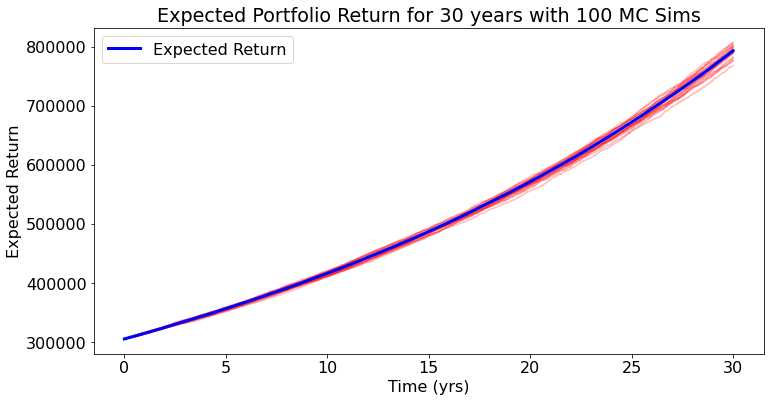

In [78]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

# Object Oriented API
fig, axes = plt.subplots(figsize=(12, 6))

for i in range(20):
    plt.plot(np.linspace(0,sim1.num_years,len(sim1.expected_portfolio_values)), sim1.portfolio_values[i,:], 'r-', alpha=0.25)

plt.plot(np.linspace(0,sim1.num_years,len(sim1.expected_portfolio_values)), sim1.expected_portfolio_values, 'b-', linewidth=3, label='Expected Return')

axes.set_xlabel('Time (yrs)')
axes.set_ylabel('Expected Return')

axes.set_title("Expected Portfolio Return for {} years with {} MC Sims".format(sim1.num_years,sim1.num_sims))

axes.legend()
plt.savefig('retireplan.png')

## After implementing a basic model, we can use a model that models volatility in a more traditional sense other than simple compound interest. We will pull stock data from the stocks listed in our portfolio and then use that data for simulation purposes

### I got this method of getting stock data from: https://asxportfolio.com/shares-monte-carlo-method-simulated-stock-portfolio

In [79]:
from pandas_datareader import data as pdr
import datetime as dt

# Import data from online
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stockList = ['AAPL'] #, 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'FB']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=3650)

meanReturns, covMatrix = get_data(stockList, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)
meanReturns

Symbols
AAPL    0.000954
dtype: float64

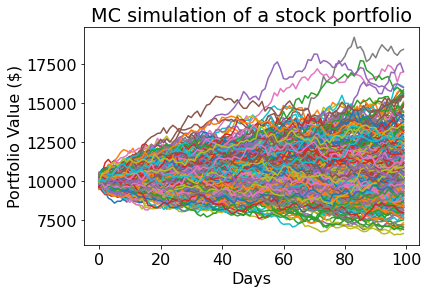

In [80]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

## Now, let's incorporate this into our PortfolioSimulation class. We just have to ensure that we are labeling all Stock assets as their proper ticker name in order to read the data correctly online. For now, we will leave Bond/Real Estate classes the same and introduce the volatility model to Stocks only

### Because we are prototyping, let's redefine all of the necessary classes here

In [161]:

## Define an over-arching class that will hold fundamental information about assets
class Asset():
    def __init__(self, name, apy, var_apy):
        self.name = name
        self.apy = apy                                # The expected Annual Percentage Yield
        self.apy_range = (apy-var_apy,apy+var_apy)    # Range of expected returns per year


## Define the separate asset classes with Asset() as the superclass
class Stock(Asset):
    def __init__(self, name, value, apy, var_apy):
        super().__init__(name, apy, var_apy)
        self.value = value          # Current stock price as a list so it is mutable
    
    def __repr__(self):
        return "Name: {}, Stock Price: ${}, Annual Return Rate Range: {}% to {}%".format(self.name,self.value,self.apy_range[0],self.apy_range[1])

class RealEstate(Asset):
    def __init__(self, name, value, apy, var_apy):
        super().__init__(name, apy, var_apy)
        self.value = value

    def __repr__(self):
        return "Name: {}, Asset Value: ${}, Annual Return Rate Range: {}% to {}%".format(self.name,self.value,self.apy_range[0],self.apy_range[1])

class Bond(Asset):
    def __init__(self, name, value, apy, var_apy):
        super().__init__(name, apy, var_apy)
        self.value = value

    def __repr__(self):
        return "Name: {}, Asset Value: ${}, Annual Return Rate Range: {}% to {}%".format(self.name,self.value,self.apy_range[0],self.apy_range[1])


## Define a portfolio class, which holds all assets and the number of each asset as tuples in a list
class Portfolio():
    def __init__(self, name):
        self.name = name
        self.assets = []
        self.stocknames = []
 
    def __repr__(self):
        result = "{}:\n".format(self.name)
        if len(self.assets) == 0:
            return "No assets."
        else:
            for i, (asset, num_assets) in enumerate(self.assets):
                result += "{}: {} x {} at ${} each\n".format(i+1, num_assets, asset.name, asset.value)

        result += "Portfolio Value: ${:,.2f}".format(self.sum_of_assets())
        return result

    def insert(self, asset_list):   # asset_list is a list of tuples containing (asset, number of asset)

        for a in asset_list:
            self.assets.append(a)
            if isinstance(a[0], Stock):
                self.stocknames.append(a[0].name)
        
        endDate = dt.datetime.now()
        startDate = endDate - dt.timedelta(days=3650)
        self.meanReturns, self.covMatrix = get_data(self.stocknames, startDate, endDate)

        

    def sum_of_assets(self):
        if len(self.assets) == 0:
            return "$0.00"
        else:
            s = 0.0
            for (a, num_assets) in self.assets:
                s += a.value*num_assets
            return s 

## Portfolio Simulation class to handle the Monte Carlo simulation
class PortfolioSimulation():
    def __init__(self,portfolio,num_years,num_sims):
        self.portfolio = portfolio
        self.num_years = num_years
        self.num_times = np.floor(365*num_years).astype(int)
        self.num_sims = num_sims
        self.mc_portfolios = np.zeros((num_sims, self.num_times+1, len(portfolio.assets)))
        self.portfolio_values = np.zeros((num_sims, self.num_times+1))
        self.expected_portfolio_values = [] 

    def __repr__(self):
        return "{} Simulation for {} years with {} Monte Carlo simulations".format(self.portfolio.name,self.num_years,self.num_sims)

    def simulate(self):

        stockslices = []
        for i, (a,num_assets) in enumerate(self.portfolio.assets):
            if isinstance(a, Stock):
                stockslices.append(i)
            else:

                # Generate a matrix of rate changes per day for the asset
                rate_changes = np.ones((self.mc_portfolios.shape[0],(self.num_times+1)))
                rate_changes[:,1:] += np.random.uniform(a.apy_range[0]/100, a.apy_range[1]/100, (self.num_sims, self.num_times)) / 365

                # Generate the cumulative rate
                rate_changes = np.cumprod(rate_changes, axis=1)

                # Compute the portfolios
                self.mc_portfolios[:,:,i] = num_assets * a.value * rate_changes

        # Stock simulation if stocks exist in portfolio
        if stockslices:

            meanM = np.full(shape=(self.num_times,len(self.portfolio.meanReturns)), fill_value=self.portfolio.meanReturns).T
            for mcindex in range(self.num_sims):
                Z = np.random.normal(size=(self.num_times, len(self.portfolio.meanReturns)))   # uncorrelated RV's
                L = np.linalg.cholesky(self.portfolio.covMatrix)                               # Cholesky decomposition to Lower Triangular Matrix
                dailyReturns = meanM + np.inner(L, Z) + 1
                dailyReturns = dailyReturns.T                                        # Correlated daily returns for individual stocks

                for i, stockindex in enumerate(stockslices):
                    self.mc_portfolios[mcindex,0,stockindex] = self.portfolio.assets[stockindex][0].value*self.portfolio.assets[stockindex][1]
                    self.mc_portfolios[mcindex,1:,stockindex] = np.cumprod(dailyReturns[:,i])*self.portfolio.assets[stockindex][0].value*self.portfolio.assets[stockindex][1]

        self.portfolio_values = np.sum(self.mc_portfolios, axis=2)    
        self.expected_portfolio_values = np.sum(np.mean(self.mc_portfolios, axis=0), axis=1)


In [162]:
s1 = Stock('AAPL', 1000, 8, 15)
s2 = Stock('MSFT', 900, 7, 12)
re1 = RealEstate('House',300000,3,10)
b1 = Bond('Treasury Note 2022',100,4,2)

p2 = Portfolio("Joey's Portfolio")
p2.insert([(s1,5),(s2,3),(re1,1),(b1,3)])
p2

Joey's Portfolio:
1: 5 x AAPL at $1000 each
2: 3 x MSFT at $900 each
3: 1 x House at $300000 each
4: 3 x Treasury Note 2022 at $100 each
Portfolio Value: $308,000.00

In [169]:
sim1 = PortfolioSimulation(p2,1,100)
sim1.simulate()
sim1.expected_portfolio_values[-1]


320331.45730547974

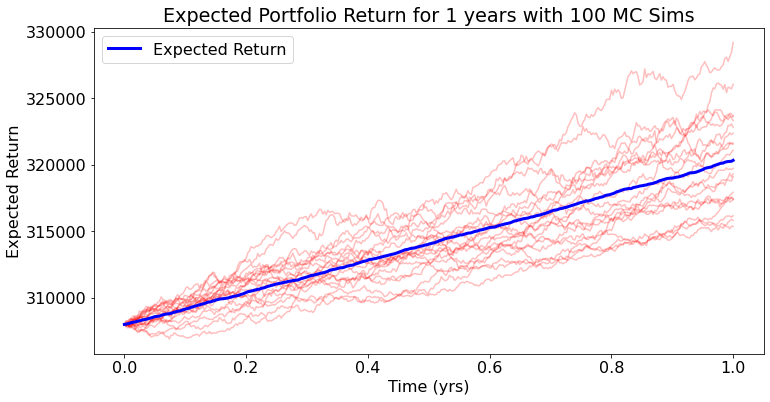

In [170]:
# Object Oriented API
fig, axes = plt.subplots(figsize=(12, 6))

for i in range(20):
    plt.plot(np.linspace(0,sim1.num_years,len(sim1.expected_portfolio_values)), sim1.portfolio_values[i,:], 'r-', alpha=0.25)

plt.plot(np.linspace(0,sim1.num_years,len(sim1.expected_portfolio_values)), sim1.expected_portfolio_values, 'b-', linewidth=3, label='Expected Return')

axes.set_xlabel('Time (yrs)')
axes.set_ylabel('Expected Return')

axes.set_title("Expected Portfolio Return for {} years with {} MC Sims".format(sim1.num_years,sim1.num_sims))

axes.legend()
plt.savefig('retireplan.png')